In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from shapely import wkt
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
import utm

In [2]:
def readFusedata_toDF(namedf):
    data = []    
    with open(namedf) as f:  
        line = f.readline()
        while line:
            d = line.split()
            data.append(d)
            line = f.readline()
    a = np.array(data)    
    df_PointCloud = pd.DataFrame()
    df_PointCloud["Latitude"] = a[:,0]
    df_PointCloud["Longitude"] = a[:,1]
    df_PointCloud["Altitude"] = a[:,2]
    df_PointCloud["Intensity"] = a[:,3]

    return df_PointCloud
pass

In [3]:
def convert_fusedata(df_PointCloud, x_min = 0.0, y_min = 0.0, z_min = 0.0):
    df_PointCloud["Latitude"] = pd.to_numeric(df_PointCloud["Latitude"])
    df_PointCloud["Longitude"] = pd.to_numeric(df_PointCloud["Longitude"])
    df_PointCloud["Altitude"] = pd.to_numeric(df_PointCloud["Altitude"])
    df_PointCloud["Intensity"] = pd.to_numeric(df_PointCloud["Intensity"])
    df_PointCloud["East"] = df_PointCloud.apply(lambda x: utm.from_latlon(x["Latitude"], x["Longitude"])[0], axis = 1)
    df_PointCloud["North"] = df_PointCloud.apply(lambda x: utm.from_latlon(x["Latitude"], x["Longitude"])[1], axis = 1)    
    if y_min == 0:
        y_min = df_PointCloud["North"].min()
    if x_min == 0:
        x_min = df_PointCloud["East"].min()   
    if z_min == 0:
        z_min = df_PointCloud["Altitude"].min()        
    utm_coordinates = utm.from_latlon(df_PointCloud.loc[0,"Latitude"], df_PointCloud.loc[0,"Longitude"])
    zoneN = utm_coordinates[2]
    zoneL = utm_coordinates[3]        
    df_PointCloud["East"] = df_PointCloud["East"] - x_min    
    df_PointCloud["North"] = df_PointCloud["North"] - y_min
    df_PointCloud["Altitude"] = df_PointCloud["Altitude"] - z_min
    
    return df_PointCloud, (x_min, y_min, z_min), (zoneN, zoneL)
pass

In [4]:
df_PointCloud = readFusedata_toDF('./final_project_data/final_project_point_cloud.fuse')
df_PointCloud, (x_min, y_min, z_min), (number, letter) = convert_fusedata(df_PointCloud)
df_xyz = df_PointCloud[["East", "North", "Altitude", "Intensity"]]
df_xyz.to_csv("./final_project_point_cloud.xyz", sep=" ", header=False, index=False)
# df_xyz.head()
# df_PointCloud.head()

In [5]:
def shapeConversion(row):
    return wkt.loads("POINT("+str(row["East"])+" "+str(row["North"])+" " +str(row["Altitude"])+")")
pass

In [6]:
def filtering_byMeanValue(df_PointCloud):
    mean = df_PointCloud["Intensity"].mean()
    std = df_PointCloud["Intensity"].std()
    dfLanes = df_PointCloud[df_PointCloud["Intensity"] > mean + 1 * std]
    dfLanes = dfLanes[dfLanes["Intensity"] < mean + 7 * std ]
    print("Filtering By Mean:")
    print("===============================================================================")
    print("Mean value for Intensity:      ", mean)
    print("Std value for Intensity:       ", std)
    print("Lower bound for Intensity:     ", mean + 1 * std)
    print("Upper bound for Intensity:     ", mean + 7 * std)
    print("Filtered points for Intensity: ", len(dfLanes))
    print("Original points for Intensity: ", len(df_PointCloud))
    print("Percentage Reduction for Intensity:  ", (len(dfLanes)/len(df_PointCloud))*100)    
    return dfLanes
pass

In [7]:
def getTrajectoryLine(traj_file='./final_project_data/trajectory.fuse',x_min=0.0,y_min=0.0,z_min=0.0):
    dfTraj = readFusedata_toDF(traj_file)
    dfTraj, (x_min,y_min,z_min),(number,letter)=convert_fusedata(dfTraj,x_min,y_min,z_min)
    dfTraj[["East", "North", "Altitude", "Intensity"]].to_csv("./trajectory.xyz", index=False)
    line = "LINESTRING("
    for index,row in dfTraj.iterrows():
        line = line + str(row["East"]) + " " + str(row["North"]) + " " + str(row["Altitude"]) + ", "
    line = line[:-2] + ")"
    trajLine = wkt.loads(line)    
    return trajLine, (x_min, y_min, z_min), (number, letter)

trajLine,(x_min, y_min, z_min),(number, letter)=getTrajectoryLine('./final_project_data/trajectory.fuse',x_min, y_min, z_min)
pass

In [8]:
def filter_by_trajLine(df_PointCloud, trajLine):
    rows = []
    for index, row in df_PointCloud.iterrows():
        distance = trajLine.distance(row["Shape"])
        if distance <= 20:
            rows.append(row)
    filtered_dfLanes = pd.DataFrame(rows,columns=['East','North','Altitude','Intensity','Shape'])    
    print("\n\n Filtering By Trajectory:")
    print("=================================================================================")
    print("Filtered points for Intensity: ", len(filtered_dfLanes))
    print("Original points for Intensity: ", len(df_PointCloud))
    print("Percentage Reduction for Intensity:  ", (len(filtered_dfLanes)/len(df_PointCloud))*100)
    return filtered_dfLanes
pass

In [9]:
dfLanes = df_xyz.copy()
dfLanes = filtering_byMeanValue(dfLanes)
dfLanes[['East', 'North', 'Altitude', 'Intensity']].to_csv("./filter_mean.xyz", index=False)
dfLanes['Shape'] = dfLanes.apply(shapeConversion, axis=1)
dfLanes = filter_by_trajLine(dfLanes, trajLine)
dfLanes[['East', 'North', 'Altitude', 'Intensity']].to_csv("./filter_trajectory.xyz", index=False)

Filtering By Mean:
Mean value for Intensity:       8.246153096095984
Std value for Intensity:        10.862899760737132
Lower bound for Intensity:      19.109052856833117
Upper bound for Intensity:      84.2864514212559
Filtered points for Intensity:  32191
Original points for Intensity:  430736
Percentage Reduction for Intensity:   7.473487240444262


 Filtering By Trajectory:
Filtered points for Intensity:  18496
Original points for Intensity:  32191
Percentage Reduction for Intensity:   57.457053213631134


In [10]:
Traj = dfLanes[["East", "North", "Altitude"]].values
Traj = StandardScaler().fit_transform(Traj)
db = DBSCAN(eps=0.06, min_samples=30).fit(Traj)
labels = db.labels_
nClusters = len(set(labels)) - (1 if -1 in labels else 0)
nNoise = list(labels).count(-1)
dfLanes["Group"] = labels
dfClusters = dfLanes[["East","North","Altitude","Group"]]
dfClusters = dfClusters[dfClusters["Group"]>=0]
dfClusters.to_csv("./clustering.xyz",index=False)
print("Total Number of Clusters:           ", nClusters)
print("Total Number of Noise points:       ", nNoise)
print("Total Number of clustered points:   ", len(dfClusters))

Total Number of Clusters:            24
Total Number of Noise points:        3435
Total Number of clustered points:    15061


In [11]:
lines = []
for cluster in range(nClusters):
    sub_dfClusters = dfClusters[dfClusters["Group"] == cluster]
    points = sub_dfClusters[["East","North", "Altitude"]].values
    distances = squareform(pdist(points))
    for i in range(0,15):
        max_index = np.argmax(distances)
        i1, i2 = np.unravel_index(max_index, distances.shape)
        distances[i1,i2] = 0.0
    max_dist = np.max(distances)
    max_index = np.argmax(distances)
    i1, i2 = np.unravel_index(max_index, distances.shape)
    p1 = sub_dfClusters.iloc[i1]
    p2 = sub_dfClusters.iloc[i2]
    lines.append(([p1["East"],p2["East"]],[p1["North"],p2["North"]],[p1["Altitude"],p2["Altitude"]]))

Number of lane markings:  24


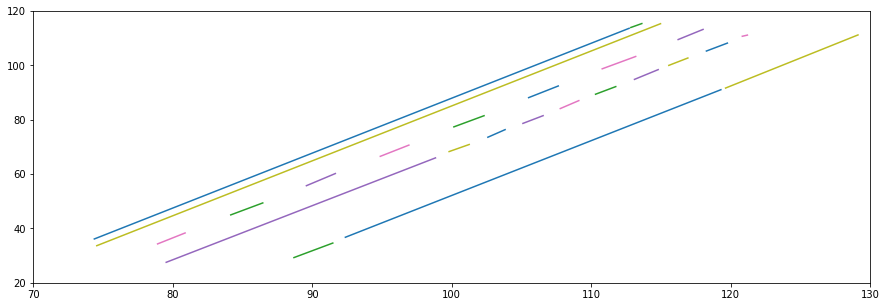

In [19]:
plt.figure(figsize=(15,5))
plt.xlim(70, 130), plt.ylim(20,120)
for l in lines:
    plt.plot(l[0], l[1], l[2])    
# plt.show()
plt.savefig('Prototype_LaneMarking1.png')
print("Number of lane markings: ", len(lines))

In [13]:
def createLine(coords):
    return wkt.loads("LINESTRING("+str(coords[0][0])+" "+str(coords[1][0])+", " +str(coords[0][1])+ " " +str(coords[1][1])+")")    
distMatrix = []
for l1 in range(len(lines)):
    prototype = []
    distances = []
    line1 = createLine(lines[l1])
    for l2 in range(len(lines)):
        line2 = createLine(lines[l2])
        d = line1.distance(line2)
        if d == 0:
            d = 100
        distances.append(d)        
    distMatrix.append(distances)
distances = np.array(distMatrix)
pass

In [14]:
fusion = set()
for row in range(distances.shape[0]):
    for column in range(distances.shape[1]):
        value = distances[row,column]
        if value < 1.0:
            min_index = min(row, column)
            max_index = max(row, column)
            fusion.add((min_index, max_index))            
fusion = list(fusion)
fClusters = []
finsih = []
fusion.sort()
for i in range(len(fusion)):
    new_cluster = list(fusion[i])
    if new_cluster[0] not in finsih and new_cluster[1] not in finsih:
        for j in range(i+1, len(fusion)):
            f = list(fusion[j])
            if (f[0] in new_cluster or f[1] in new_cluster) and f[0] not in finsih:
                new_cluster.extend(f)
        fClusters.append(list(set(new_cluster)))
        finsih.extend(list(set(new_cluster)))        
fused_lines = [item for sublist in fClusters for item in sublist]
for i in range(distances.shape[0]):
    if i not in fused_lines:
        fClusters.append([i])

In [15]:
final_LaneM = []
for cluster in fClusters:
    if len(cluster) == 1:
        final_LaneM.append(lines[cluster[0]])
    else:
        points = []
        for segment in cluster:
            l = lines[segment]
            points.append([l[0][0], l[1][0], l[2][0]])
            points.append([l[0][1], l[1][1], l[2][1]])
        points = np.array(points)
        distances = squareform(pdist(points))
        max_dist = np.max(distances)
        max_index = np.argmax(distances)
        i1, i2 = np.unravel_index(max_index, distances.shape)        
        p1 = points[i1]
        p2 = points[i2]
        final_LaneM.append(([p1[0], p2[0]],[p1[1], p2[1]], [p1[2], p2[2]]))

Total Number of final lane markings:  22


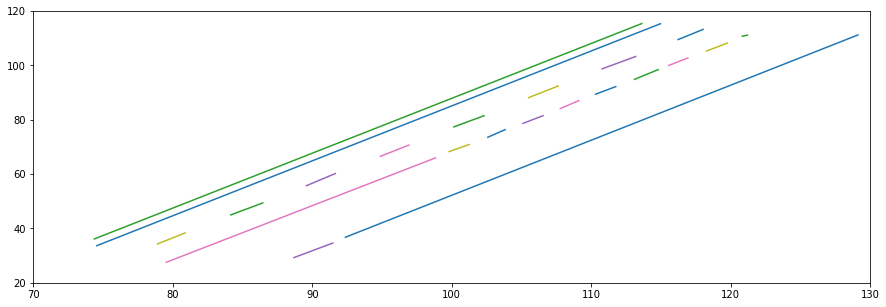

In [20]:
plt.figure(figsize=(15,5))
plt.xlim(70, 130), plt.ylim(20,120)
for l in final_LaneM:
    plt.plot(l[0], l[1], l[2])    
plt.savefig('Prototype_LaneMarking2.png')
print("Total Number of final lane markings: ", len(final_LaneM))

In [27]:
op_rows = []
for line in final_LaneM:
    xstart = line[0][0] + x_min
    ystart = line[1][0] + y_min
    zstart = line[2][0] + z_min
    xend = line[0][1] + x_min
    yend = line[1][1] + y_min
    zend = line[2][1] + z_min
    (start_lat, start_lon) = utm.to_latlon(xstart,ystart,number, letter)
    (end_lat, end_lon) = utm.to_latlon(xend,yend,number, letter)
    op_rows.append([start_lat, start_lon, zstart, end_lat, end_lon, zend])    
res = pd.DataFrame(op_rows, columns=[" Start_Latitude", "Start_Longitude", "Start_Altitude","End_latitude", "End_Longitude", "End_Altitude"])
res.to_csv("./res.csv", header=True, index=False)